<a href="https://colab.research.google.com/github/dansarmiento/machine_learning_notebooks/blob/main/Rainfall_Prediction_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Explore and perform feature engineering on a real-world data set
- Build a classifier pipeline and optimize it using grid search cross validation
- Evaluate your model by interpreting various performance metrics and visualizations
- Implement a different classifier by updating your pipeline
- Use an appropriate set of parameters to search over in each case

https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
# https://docs.google.com/spreadsheets/d/1vQWCncS1dkiLZ7e3-Mv8V0gNdltfxO2_2cCibkr1joY/edit?usp=sharing
sheet_id = "1vQWCncS1dkiLZ7e3-Mv8V0gNdltfxO2_2cCibkr1joY"
sheet_name = "Sheet1"

gsheet_url = "https://docs.google.com/spreadsheets/d/{}/gviz/tq?tqx=out:csv&sheet={}".format(sheet_id,sheet_name)
df = pd.read_csv(gsheet_url)
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/','_')
df.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,...,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


| Field           | Description                                                           | Unit              | Type   |
|-----------------|-----------------------------------------------------------------------|-------------------|--------|
| Date            | Date of the Observation in YYYY-MM-DD                                 | Date              | object |
| Location        | Location of the Observation                                            | Location          | object |
| MinTemp         | Minimum temperature                                                    | Celsius           | float  |
| MaxTemp         | Maximum temperature                                                    | Celsius           | float  |
| Rainfall        | Amount of rainfall                                                     | Millimeters       | float  |
| Evaporation     | Amount of evaporation                                                  | Millimeters       | float  |
| Sunshine        | Amount of bright sunshine                                              | hours             | float  |
| WindGustDir     | Direction of the strongest gust                                        | Compass Points    | object |
| WindGustSpeed   | Speed of the strongest gust                                            | Kilometers/Hour   | object |
| WindDir9am      | Wind direction averaged over 10 minutes prior to 9am                  | Compass Points    | object |
| WindDir3pm      | Wind direction averaged over 10 minutes prior to 3pm                  | Compass Points    | object |
| WindSpeed9am    | Wind speed averaged over 10 minutes prior to 9am                      | Kilometers/Hour   | float  |
| WindSpeed3pm    | Wind speed averaged over 10 minutes prior to 3pm                      | Kilometers/Hour   | float  |
| Humidity9am     | Humidity at 9am                                                       | Percent           | float  |
| Humidity3pm     | Humidity at 3pm                                                       | Percent           | float  |
| Pressure9am     | Atmospheric pressure reduced to mean sea level at 9am                 | Hectopascal       | float  |
| Pressure3pm     | Atmospheric pressure reduced to mean sea level at 3pm                 | Hectopascal       | float  |
| Cloud9am        | Fraction of the sky obscured by cloud at 9am                          | Eights            | float  |
| Cloud3pm        | Fraction of the sky obscured by cloud at 3pm                          | Eights            | float  |
| Temp9am         | Temperature at 9am                                                    | Celsius           | float  |
| Temp3pm         | Temperature at 3pm                                                    | Celsius           | float  |
| RainToday       | If there was at least 1mm of rain today                               | Yes/No            | object |
| RainTomorrow    | If there is at least 1mm of rain tomorrow                             | Yes/No            | object |


In [3]:
# look at how many rows with nulls
# there's a lot, but we will drop the rows with nulls to keep things simple
df.isnull().sum()

,0
date,0
location,0
mintemp,1485
maxtemp,1261
rainfall,3261
evaporation,62790
sunshine,69835
windgustdir,10326
windgustspeed,10263
winddir9am,10566


In [4]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(145460, 23)
(56420, 23)


If we adjust our approach and aim to predict today’s rainfall using historical weather data up to and including yesterday, then we can legitimately utilize all of the available features. This shift would be particularly useful for practical applications, such as deciding whether you will bike to work today.

With this new target, we should update the names of the rain columns accordingly to avoid confusion.

In [5]:
df = df.rename(columns={'raintoday': 'rainyesterday',
                        'raintomorrow': 'raintoday'
                        })

Would the weather patterns have the same predictability in vastly different locations in Australia? I would think not.
The chance of rain in one location can be much higher than in another. Using all of the locations requires a more complex model as it needs to adapt to local weather patterns.
Let's see how many observations we have for each location, and see if we can reduce our attention to a smaller region.

You could do some research to group cities in the Location column by distance, which I've done for you behind the scenes.
I found that Watsonia is only 15 km from Melbourne, and the Melbourne Airport is only 18 km from Melbourne.
Let's group these three locations together and use only their weather data to build our localized prediction model.
Because there might still be some slight variations in the weather patterns we'll keep Location as a categorical variable.

In [6]:
df = df[df.location.isin(['Melbourne', 'Watsonia', 'Melbourne Airport'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4628 entries, 67200 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4628 non-null   object 
 1   location       4628 non-null   object 
 2   mintemp        4628 non-null   float64
 3   maxtemp        4628 non-null   float64
 4   rainfall       4628 non-null   float64
 5   evaporation    4628 non-null   float64
 6   sunshine       4628 non-null   float64
 7   windgustdir    4628 non-null   object 
 8   windgustspeed  4628 non-null   float64
 9   winddir9am     4628 non-null   object 
 10  winddir3pm     4628 non-null   object 
 11  windspeed9am   4628 non-null   float64
 12  windspeed3pm   4628 non-null   float64
 13  humidity9am    4628 non-null   float64
 14  humidity3pm    4628 non-null   float64
 15  pressure9am    4628 non-null   float64
 16  pressure3pm    4628 non-null   float64
 17  cloud9am       4628 non-null   float64
 18  cloud3pm

**Extracting a seasonality feature**

Now consider the Date column. We expect the weather patterns to be seasonal, having different predictablitiy levels in winter and summer for example.
There may be some variation with Year as well, but we'll leave that out for now. Let's engineer a Season feature from Date and drop Date afterward, since it is most likely less informative than season. An easy way to do this is to define a function that assigns seasons to given months, then use that function to transform the Date column.

In [7]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif (month == 3) or (month == 4) or (month == 5):
        return 'Autumn'
    elif (month == 6) or (month == 7) or (month == 8):
        return 'Winter'
    elif (month == 9) or (month == 10) or (month == 11):
        return 'Spring'

In [8]:
# Convert the 'Date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Apply the function to the 'Date' column
df['deason'] = df['date'].apply(date_to_season)

df=df.drop(columns='date')
df

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,...,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,rainyesterday,raintoday,deason
67200,Melbourne,9.5,15.4,2.0,2.8,7.0,W,63.0,W,W,...,38.0,1006.8,1010.3,1.0,7.0,11.0,14.6,Yes,No,Winter
67201,Melbourne,11.0,14.5,0.6,5.2,4.0,W,63.0,W,WSW,...,52.0,1013.4,1016.2,7.0,4.0,11.8,13.7,No,Yes,Winter
67202,Melbourne,8.4,14.1,1.4,2.0,0.8,W,39.0,W,W,...,58.0,1024.8,1024.3,7.0,7.0,10.6,13.9,Yes,No,Winter
67203,Melbourne,9.1,14.5,0.6,1.8,4.2,E,19.0,NNW,N,...,49.0,1030.2,1029.0,7.0,6.0,10.2,13.1,No,No,Winter
67204,Melbourne,4.3,15.5,0.0,0.8,8.4,N,52.0,N,NNE,...,52.0,1028.9,1024.9,2.0,5.0,5.5,14.6,No,No,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80992,Watsonia,3.6,14.5,0.0,2.4,8.8,NNE,41.0,ENE,NNE,...,66.0,1028.4,1025.0,1.0,7.0,5.2,13.8,No,No,Winter
80994,Watsonia,4.8,13.3,0.4,0.6,0.0,NNW,24.0,NE,NNE,...,63.0,1028.5,1025.1,7.0,7.0,5.6,12.4,No,No,Winter
80995,Watsonia,5.6,13.1,0.0,1.6,6.0,NNW,52.0,NE,N,...,67.0,1019.0,1014.0,1.0,7.0,8.8,11.6,No,Yes,Winter
80996,Watsonia,6.9,12.1,3.2,1.8,5.6,SSW,24.0,WNW,SW,...,61.0,1018.7,1017.3,2.0,7.0,7.9,11.0,Yes,No,Winter


In [10]:
X = df.drop(columns='raintoday', axis=1)
y = df['raintoday']

In [11]:
y.value_counts(normalize=True)

,proportion
raintoday,
No,0.750432
Yes,0.249568


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4628 entries, 67200 to 80997
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location       4628 non-null   object 
 1   mintemp        4628 non-null   float64
 2   maxtemp        4628 non-null   float64
 3   rainfall       4628 non-null   float64
 4   evaporation    4628 non-null   float64
 5   sunshine       4628 non-null   float64
 6   windgustdir    4628 non-null   object 
 7   windgustspeed  4628 non-null   float64
 8   winddir9am     4628 non-null   object 
 9   winddir3pm     4628 non-null   object 
 10  windspeed9am   4628 non-null   float64
 11  windspeed3pm   4628 non-null   float64
 12  humidity9am    4628 non-null   float64
 13  humidity3pm    4628 non-null   float64
 14  pressure9am    4628 non-null   float64
 15  pressure3pm    4628 non-null   float64
 16  cloud9am       4628 non-null   float64
 17  cloud3pm       4628 non-null   float64
 18  temp9am 

In [15]:
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [16]:
# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [18]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [19]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [21]:
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['mintemp',
                                                                          'maxtemp',
                                                                          'rainfall',
                                                                          'evaporation',
                                                                          'sunshine',
                                                                          'windgustspeed',
                                                                          'windspeed9am',
                                                                          'windspeed3pm',
                                                                          'humidity9am',
                                                                          'humidity3pm',
                                                                          'pressure9am',
                                                                          'pr...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['location',
                                                                          'windgustdir',
                                                                          'winddir9am',
                                                                          'winddir3pm',
                                                                          'rainyesterday',
                                                                          'deason'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

In [22]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.84


In [23]:
test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Test set score: 0.82


In [24]:
y_pred = grid_search.predict(X_test)

In [25]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

          No       0.84      0.94      0.89       695
         Yes       0.71      0.48      0.57       231

    accuracy                           0.82       926
   macro avg       0.78      0.71      0.73       926
weighted avg       0.81      0.82      0.81       926



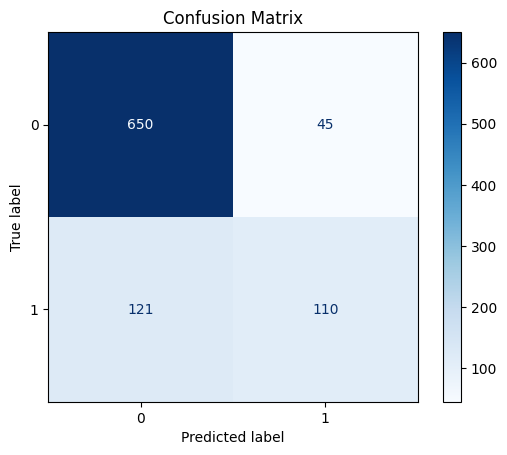

In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [27]:
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

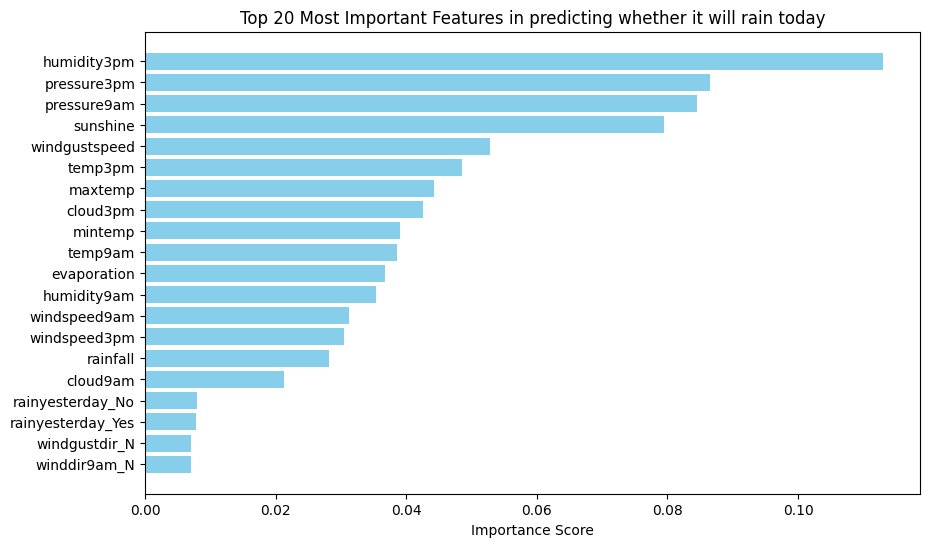

In [28]:
# Combine numeric and categorical feature names
feature_names = numeric_features + list(grid_search.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

N = 20  # Change this number to display more or fewer features
top_features = importance_df.head(N)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

In [29]:
# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
grid_search.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    # 'classifier__n_estimators': [50, 100],
    # 'classifier__max_depth': [None, 10, 20],
    # 'classifier__min_samples_split': [2, 5],
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

grid_search.param_grid = param_grid

# Fit the updated pipeline with LogisticRegression
grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=No

              precision    recall  f1-score   support

          No       0.84      0.92      0.88       695
         Yes       0.66      0.49      0.56       231

    accuracy                           0.81       926
   macro avg       0.75      0.70      0.72       926
weighted avg       0.80      0.81      0.80       926



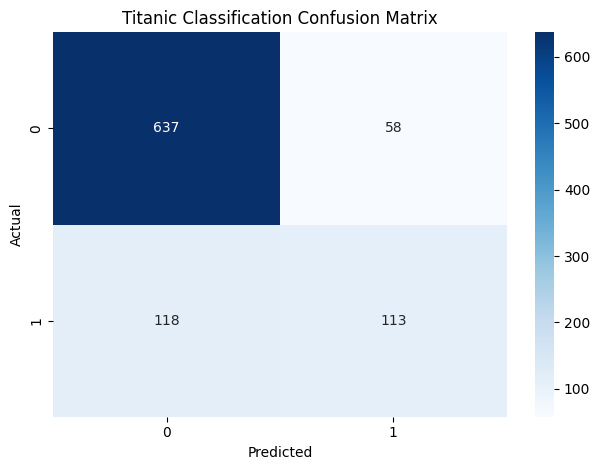

In [30]:
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()